# Mask R-CNN - Train on LFW Dataset


This notebook shows how to train Mask R-CNN on the lfw dataset. The idea is to train a model that can not only detect a face, but segment it so that we can easily remove the background.

In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

## Configurations

In [12]:
class FacesConfig(Config):
    """Configuration for training on the lfw dataset
    Derives from the base Config class and overrides values specific
    to the lfw dataset.
    """
    # Give the configuration a recognizable name
    NAME = "faces"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + face and hair

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = FacesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           faces
NUM_CLASSES                    3
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         200

## Notebook Preferences

In [13]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the faces dataset, `load_faces()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [14]:
class LFWCollector:
    
    def build_paths(image_dir, label_dir, image_subdir, label_file):
        image_file = label_file[:-3] + 'jpg'
        image_path = os.path.join(image_dir, image_subdir, image_file)
        label_path = os.path.join(label_dir, label_file)
        return [image_path, label_path]
    
    def get_image_paths(image_dir, label_dir):
        label_files = []
        train_files = []

        for filename in os.listdir(label_dir):
            if filename.endswith(".ppm"):
                label_files.append(filename)

        for label_file in label_files:
            image_file = label_file[:-9]
            train_files.append(build_paths(image_dir, label_dir, image_file, label_file))

        return train_files

In [15]:
class FacesDataset(utils.Dataset):
    """Generates the lfw dataset
    """
    
    def __init__(self):
        self.images = []
        super().__init__()

    def load_file(self):
        
        with open("/home/arthur/code/train3.txt", "r") as lines:
            for line in lines:
                tokens = line.split(' ')
                self.images.append([tokens[0], tokens[1]])
    
        img = cv2.imread(self.images[0][0])
        self.img_height = img.shape[0]
        self.img_width = img.shape[1]


    def load_faces(self, start, end, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("faces", 1, "face")
        #self.add_class("faces", 2, "hair")

        for idx, img in enumerate(self.images):
            if idx < start:
                continue
            if idx > end:
                continue
            bg_color = np.array([0, 0, 255])
            self.add_image("faces", image_id=idx, path=img[0],
                           width=width, height=height,
                           bg_color=bg_color)

    def load_image(self, image_id):
        img = cv2.imread(self.images[image_id][0])
        height, width = img.shape[:2]
        img = cv2.resize(img,(width+6, height+6), interpolation = cv2.INTER_CUBIC)
        return img
    
    def image_reference(self, image_id):
        """Return the face data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "faces":
            return info["faces"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for faces of the given image ID.
        """
        mask = cv2.imread(self.images[image_id][1][:-1]) # todo should remove \n when loading files
        height, width = mask.shape[:2]
        mask = cv2.resize(mask,(width+6, height+6), interpolation = cv2.INTER_CUBIC)
        class_ids = np.array([1])
#         hair = np.array([255, 0, 0])
#         if hair in mask:
#             classes.append(2)

        info = self.image_info[image_id]
        binary_mask = np.zeros([info['height'], info['width'], 1], dtype=np.uint8)
        
        for r in range(mask.shape[0]):
            for c in range(mask.shape[1]):
                g = mask[r][c][1]
                if g == 255:
                    binary_mask[r][c] = 1
        
        return binary_mask, class_ids.astype(np.int32)
#         for r in img.shape[0]:
#             for c in img.shape[1]:
#                 print(img[r][c])
            
        # Need to return the mask
        # The mask is an array of arrays with the number of instances long for the nested array
        # The first array should be height x width long (Number of pixels)
        # The value of the array at the position of [height][width] should be the number of instances at that
        # pixel location
        # E.e. An image 4 pixels wide and high will have a 3d array, 4 wide, 4 long and the number of instance deep
        # for lfw it will be 250 250 2
        # Also need to return a 1D array of what class is in it, either [0, 1] for face and hair or [0] for just face
        

In [16]:
dataset_train = FacesDataset()
dataset_train.load_file()
# Training dataset
dataset_train.load_faces(0, 500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = FacesDataset()
dataset_val.load_file()
dataset_val.load_faces(501, 551, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

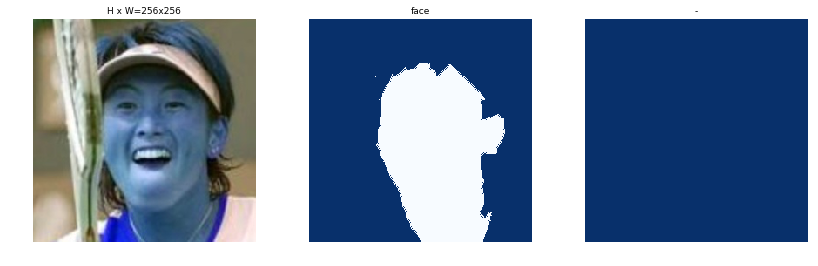

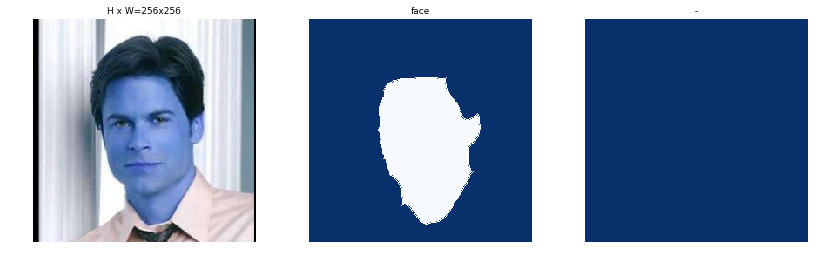

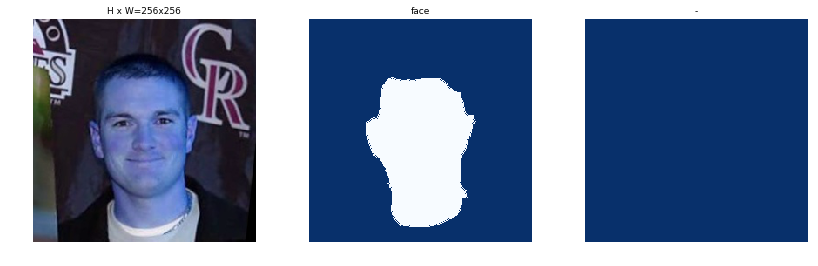

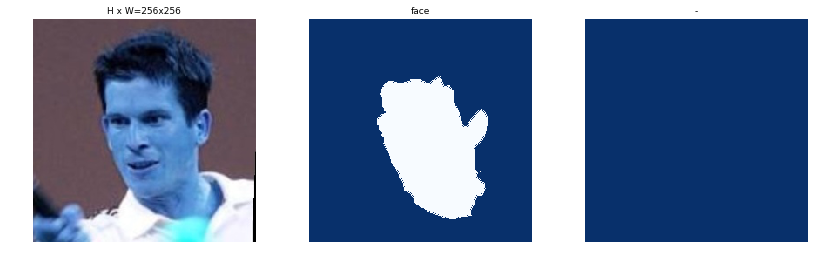

In [17]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 2)

## Ceate Model

In [18]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [19]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [20]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/arthur/code/Mask_RCNN/logs/faces20180111T1433/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_

/home/arthur/anaconda2/envs/mask_rcnn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/arthur/anaconda2/envs/mask_rcnn/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 81s 805ms/step - loss: 1.2047 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3584 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.4462 - mrcnn_mask_loss: 0.3085 - val_loss: 0.6691 - val_rpn_class_loss: 0.0263 - val_rpn_bbox_loss: 0.2266 - val_mrcnn_class_loss: 0.0318 - val_mrcnn_bbox_loss: 0.1962 - val_mrcnn_mask_loss: 0.1882


In [21]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/arthur/code/Mask_RCNN/logs/faces20180111T1433/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_

/home/arthur/anaconda2/envs/mask_rcnn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/arthur/anaconda2/envs/mask_rcnn/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
100/100 [==============================] - 107s 1s/step - loss: 0.7197 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2562 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1871 - mrcnn_mask_loss: 0.2404 - val_loss: 0.3887 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.0803 - val_mrcnn_class_loss: 0.0073 - val_mrcnn_bbox_loss: 0.1048 - val_mrcnn_mask_loss: 0.1940


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_faces.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(FacesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/arthur/code/Mask_RCNN/logs/shapes20180111T1327/mask_rcnn_shapes_0002.h5


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (1, 4)                min:   66.00000  max:  207.00000
gt_bbox                  shape: (1, 4)                min:   66.00000  max:  207.00000
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000


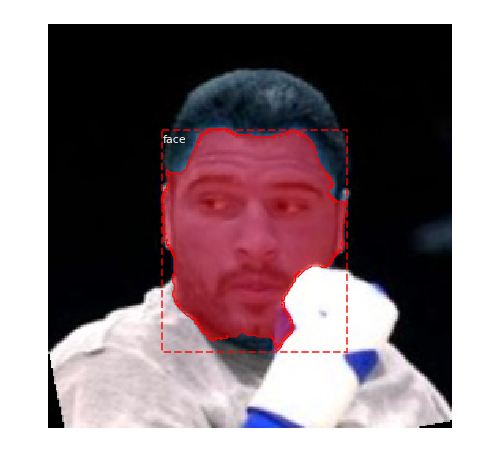

In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 11)               min:    0.00000  max:  256.00000
0.24283456802368164


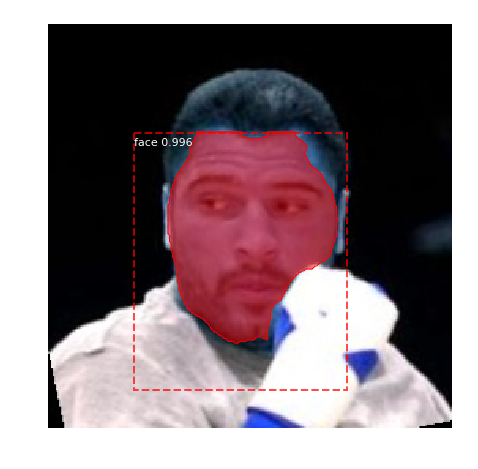

In [18]:
import time
start = time.time()
results = model.detect([original_image], verbose=1)
end = time.time()
print(end - start)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
total = 0
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    total += r["scores"][0]
    
print('Avg score: ', total / 10)
print("mAP: ", np.mean(APs))

Avg score:  0.994983428717
mAP:  1.0
